# 🗞️ Part 1: BBC News Classification

###  🕊️ Challenge Overview

#### 📝 Description

Text documents are one of the richest sources of data for businesses.

In this competition, we will use a **public dataset from the BBC** consisting of **2,225 news articles**, each labeled with one of the following five categories:

- 🏢 business
- 🎬 entertainment
- 🏛 politics
- 🏅 sport
- 💻 tech


#### 📚 Dataset Overview

The dataset is split as follows:

- **1,490 articles** for training
- **735 articles** for testing

#### 🎯 Objective

Build a model that accurately classifies previously unseen articles into one of the five categories.

#### 🔗 Helpful Resource

A helpful resource for understanding the problem:
[Google Cloud Blog - Problem-Solving with ML: Automatic Document Classification](https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification)

#### 📊 Evaluation

- **Metric**: Accuracy
- 🧾 **Submission Format**:
  - File must contain a header
  - Two required columns:
    - `ArticleId` (from test file)
    - `Category` (one of: sport, tech, business, entertainment, politics)

#### 💡 Tips

Ensure your output matches the required structure for successful evaluation.

## 🧪 Analysis Plan

The goal of this project is to classify BBC news articles into five categories:
**business, entertainment, politics, sport, and tech**.

To approach this problem, I structured the analysis into the following stages:

1. **Exploratory Data Analysis (EDA)**  
   I inspected the class distribution and analyzed the length of the news articles. Visualizations such as histograms and faceted plots were used to understand the text length variation across categories and check for class imbalance.

1. **Feature Extraction using TF-IDF**  
   I applied the TF-IDF (Term Frequency-Inverse Document Frequency) transformation to convert raw text into numerical features. This helps highlight important words in each article while down-weighting common terms.

1. **Dimensionality Reduction via Matrix Factorization (NMF)**  
   To reduce the dimensionality of the TF-IDF vectors, I used Non-negative Matrix Factorization (NMF). This helped extract latent topics that serve as compressed representations of the original articles.

1. **Classification**  
   I trained a logistic regression classifier on the NMF features to predict the news category. I also plan to compare this performance with a baseline classifier trained directly on raw TF-IDF features.

1. **Hyperparamater Tuning**
  I played with a few `n_components` to see if I could improve on my original `n_components=5` NMF model.

1. **Evaluation & Comparison**  
  I evaluated the classification performance using accuracy, confusion matrices, and classification reports. I compared the NMF-based model with a TF-IDF-only model and examine data efficiency by training on smaller subsets of the data.

1. **Kaggle Submission**  
   The model is used to generate predictions for the test set, which are formatted into a CSV file and submitted to the Kaggle competition leaderboard.


## 🖥️ Initialization

In [2]:
# mount `MyDrive`
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment/

Mounted at /content/drive
/content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment


In [3]:
from google.colab import userdata
import os
import json
# Get the API key from the Secrets Manager
kaggle_api_key = userdata.get('KAGGLE_API_KEY')

# Create the .kaggle directory and the kaggle.json file
!mkdir -p ~/.kaggle
!echo "$kaggle_api_key" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle

# Assuming both secrets are available
kaggle_username = userdata.get("KAGGLE_USERNAME")  # You need to set this too
kaggle_key = userdata.get("KAGGLE_API_KEY")

# Double-check both are present
assert kaggle_username is not None, "Missing KAGGLE_USERNAME"
assert kaggle_key is not None, "Missing KAGGLE_API_KEY"

# Write the kaggle.json file
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)


# Write kaggle.json
kaggle_config = {
    "username": kaggle_username,
    "key": kaggle_key
}

total 4
-rw------- 1 root root 33 Jun 23 14:21 kaggle.json


### 🥣 Load Data from Kaggle

In [4]:
# # Copy the kaggle files
# !kaggle competitions download -c learn-ai-bbc -p /content || echo "Failed"
# # Move the files
# !mv /content/learn-ai-bbc.zip /content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment/data/
# %cd /content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment/data/
# !ls -l /content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment/data/
#  # Extract the files
# !unzip /content/drive/MyDrive/notebooks/dtsa-5510/week_4_programming_assignment/data/learn-ai-bbc.zip -d ./data

### 🗽 Bring in the Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# c'est magique
%matplotlib inline

## 📁 Load and Inspect the Data

In [6]:
data = pd.read_csv('./data/BBC News Train.csv')
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [7]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


## 🧼 Clean the Data

In [8]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Normalize column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

# Rename `ArticleID` to `article_id`
data = data.rename(columns={'articleid': 'article_id'})

# Normalize rows and filter out unnecessary words
def clean_text(text):
  # Lowercase
  text = text.lower()
  # Remove punctuation and digits
  text = re.sub(r'[^a-z\s]', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  # Optionally remove stopwords (if needed)
  return text

def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

data['text'] = data['text'].apply(clean_text)

data['text'] = data['text'].apply(remove_stopwords)

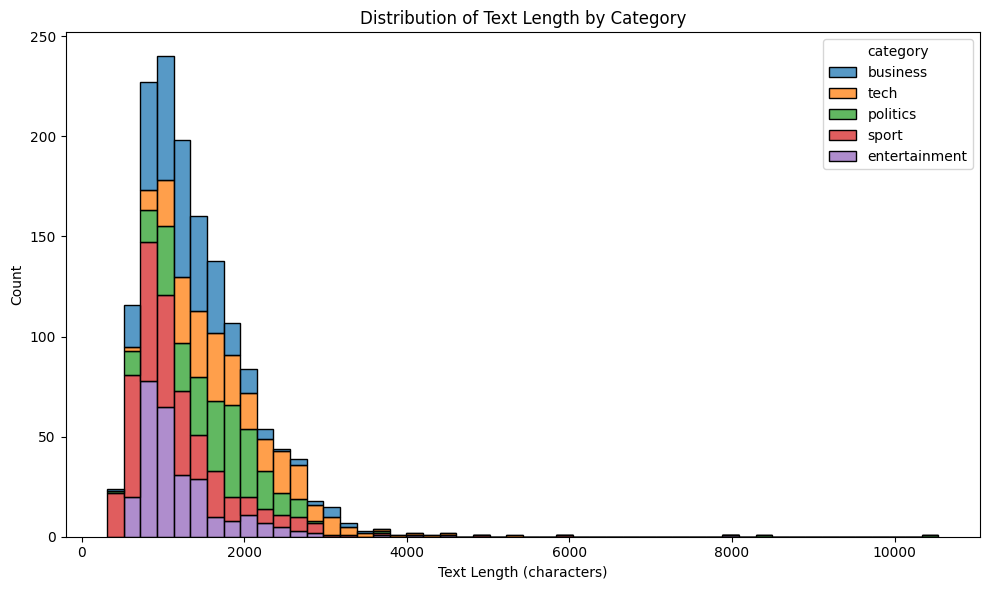

In [12]:
# Show class distribution
data['category'].value_counts()

# Are there any longbois?
data['text_length'] = data['text'].str.len()

# Plot distribution of text length per category
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', hue='category', multiple='stack', bins=50, kde=False)
plt.title("Distribution of Text Length by Category")
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


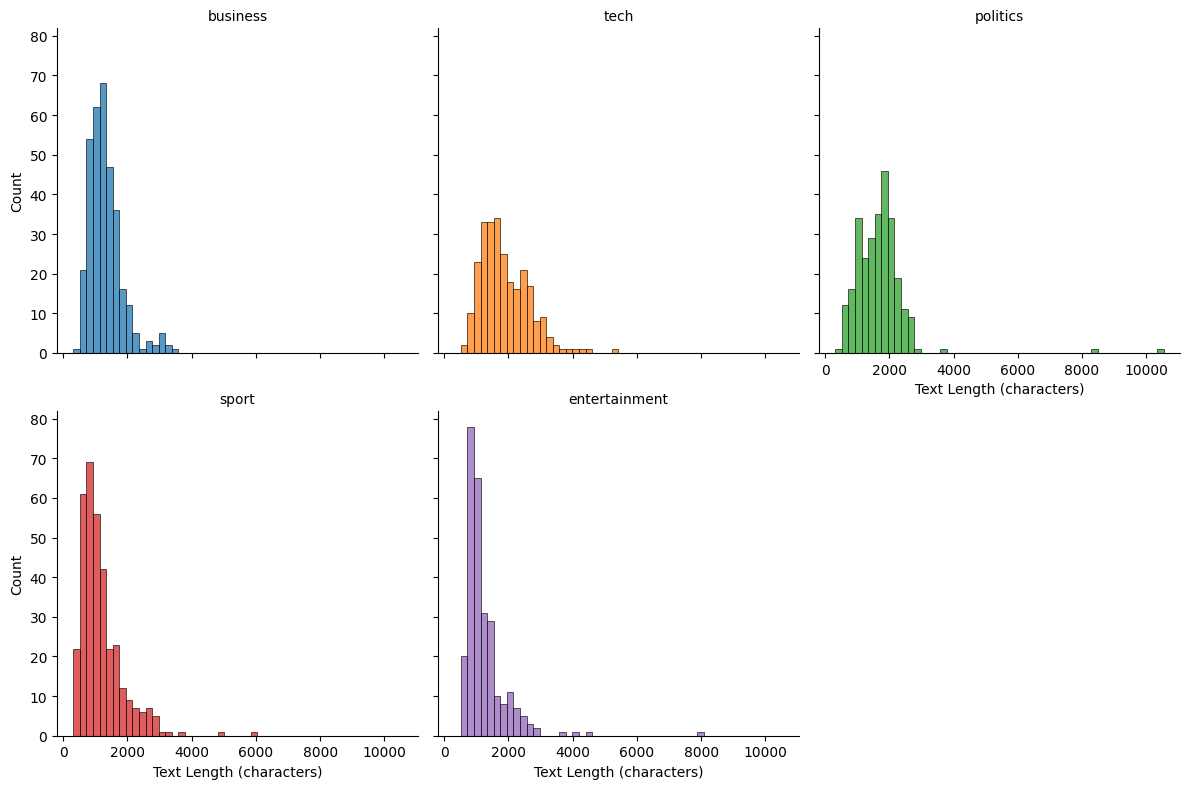

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate text length if not already done
data['text_length'] = data['text'].str.len()

# Define consistent color palette
palette = {
    "business": "#1f77b4",
    "tech": "#ff7f0e",
    "politics": "#2ca02c",
    "sport": "#d62728",
    "entertainment": "#9467bd"
}

# Fix the bar widths
min_len = data['text_length'].min()
max_len = data['text_length'].max()
bins = np.linspace(min_len, max_len, 51)  # 50 equal-width bins

# Create FacetGrid with shared bins
g = sns.FacetGrid(data, col="category", col_wrap=3, height=4, sharex=True, sharey=True,
                  palette=palette, hue="category")
g.map(sns.histplot, "text_length", bins=bins, kde=False, color=None)

g.set_titles("{col_name}")
g.set_axis_labels("Text Length (characters)", "Count")
plt.tight_layout()
plt.show()

## 🙀 What the TF-IDF?

TF-IDF stands for **Term Frequency–Inverse Document Frequency**. This is a numerical statistic used to transform textual data into features that reflect the **importance of a word** in a document relative to a collection of documents.

TF-IDF helps emphasize words that are:
- **frequent within a specific document** (important for that article), but
- **rare across the entire corpus** (not just common filler words like "the" or "and").


### 🧮 TF-IDF Formula

Each word's weight is computed as:

$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$

Where:
- $\text{TF}(t, d)$: **Term Frequency**; how often term *t* appears in document *d*
- $\text{IDF}F(t)$: **Inverse Document Frequency**; a log-scaled inverse fraction of the number of documents containing the term *t*

$
\text{IDF}(t) = \log\left(\frac{N}{1 + \text{DF}(t)}\right)
$

- $N$: Total number of documents  
- $\text{DF}(t)$: Number of documents containing the term *t*

### 🧠 Why Use TF-IDF?

- It reduces the weight of **very common words** that don’t help distinguish documents.
- It increases the weight of **informative terms** that are **unique or rare**, making it more effective for tasks like document classification or clustering.

In this project, TF-IDF transforms raw news article text into a matrix of weighted word features, which I use for dimensionality reduction (via NMF) and classification.

### 🔗 Source

[TF-IDF: LearnDataSci](https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/#:~:text=Term%20Frequency%20%2D%20Inverse%20Document%20Frequency%20(TF%2DIDF)%20is,%2C%20relative%20to%20a%20corpus)

## 🦖 Apply TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000, # Keep it small
    stop_words='english',
    lowercase=True
    )
X_tfidf = vectorizer.fit_transform(data['text'])

# Convert sparse matrix to dense DataFrame for exploration
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out()
    )

# Attach labels for downstream use
tfidf_df['category'] = data['category']

## 💢 PCA

In [24]:
from sklearn.decomposition import PCA

X_dense = X_tfidf.toarray()
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_dense)

# Look, I like pretty colours too. But R^612 is kind of hard to graph...
# ValueError: Shape of passed values is (1490, 612), indices imply (1490, 2)
# pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
# pca_df['category'] = data['category'].values

# # Plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="category", palette=palette)
# plt.title("TF-IDF Text Data Reduced with PCA")
# plt.tight_layout()
# plt.show()

## 🧠 Matrix Factorization Model

In [42]:
from sklearn.decomposition import NMF

def nmf_fun(X, n_components):
  nmf = NMF(
      n_components=n_components,
      random_state=42069 # nICE
  )
  W = nmf.fit_transform(X)
  H = nmf.components_
  return W, H

W, H = nmf_fun(X_tfidf, 5)

# Fit the model
W = nmf.fit_transform(X_tfidf)  # Document-topic matrix # shape: (n_samples, 5)
H = nmf.components_             # Topic-word matrix

# Top Words per Category
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    top_features = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_features)}")

Topic 1: mr, labour, blair, election, said, party, brown, government, minister, prime
Topic 2: game, england, win, said, cup, wales, ireland, players, play, match
Topic 3: bn, said, growth, market, year, firm, economy, company, shares, sales
Topic 4: film, best, awards, award, actor, actress, films, director, festival, won
Topic 5: people, mobile, said, music, technology, phone, software, users, digital, microsoft


### 🧜‍♂️ Train the Classifier

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(W,
  data['category'],
  test_size=0.2,
  random_state=42069 # Nice
  )

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.91      0.97      0.94        74
entertainment       0.98      0.80      0.88        56
     politics       0.87      0.89      0.88        44
        sport       0.93      0.99      0.96        72
         tech       0.90      0.90      0.90        52

     accuracy                           0.92       298
    macro avg       0.92      0.91      0.91       298
 weighted avg       0.92      0.92      0.92       298



### 🧂 Confusion Matrix

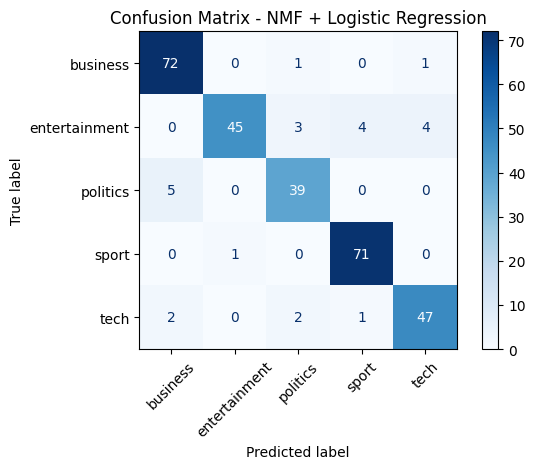

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - NMF + Logistic Regression")
plt.tight_layout()
plt.show()

### 🎶 Hyperparameter Tuning

In [57]:
charted_metrics = []  # or rows = []

for k in [5, 7, 10, 15, 20]:
    W, H = nmf_fun(X_tfidf, k)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        W, data['category'], test_size=0.2, random_state=42069
    )

    # Train classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Print results
    print(f"\n=== n_components = {k} ===")
    print(classification_report(y_test, y_pred))

    # Extract and store metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    for label in y_test.unique():
        if label in report:
            charted_metrics.append({
                "k": k,
                "category": label,
                "precision": report[label]["precision"],
                "recall": report[label]["recall"],
                "f1": report[label]["f1-score"]
            })


=== n_components = 5 ===
               precision    recall  f1-score   support

     business       0.91      0.97      0.94        74
entertainment       0.98      0.80      0.88        56
     politics       0.87      0.89      0.88        44
        sport       0.93      0.99      0.96        72
         tech       0.90      0.90      0.90        52

     accuracy                           0.92       298
    macro avg       0.92      0.91      0.91       298
 weighted avg       0.92      0.92      0.92       298


=== n_components = 7 ===
               precision    recall  f1-score   support

     business       0.92      0.97      0.95        74
entertainment       0.96      0.91      0.94        56
     politics       0.91      0.91      0.91        44
        sport       0.94      1.00      0.97        72
         tech       0.98      0.87      0.92        52

     accuracy                           0.94       298
    macro avg       0.94      0.93      0.94       298
 weighte

### 🧑‍🍳 Charted Metrics

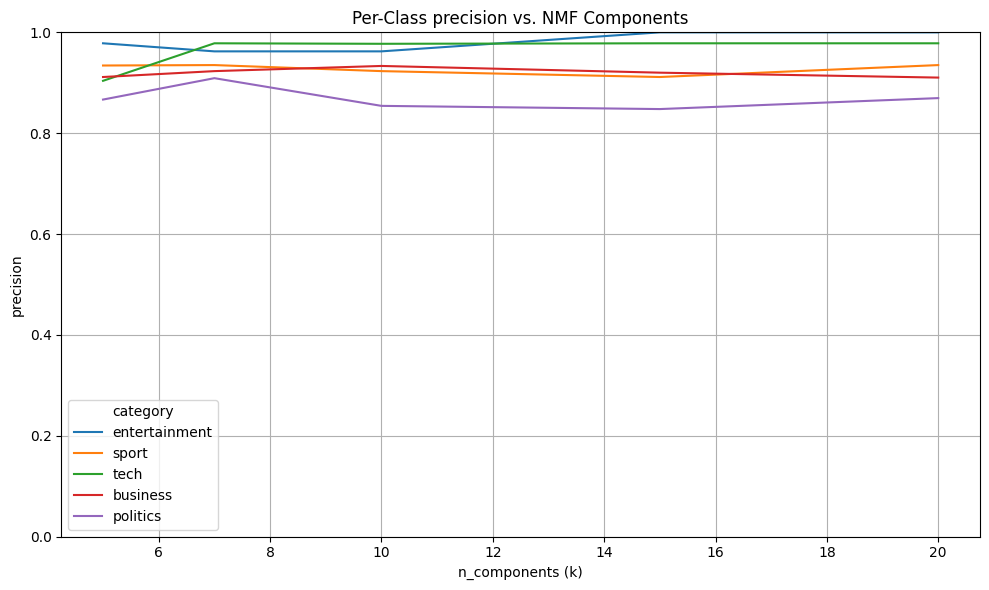

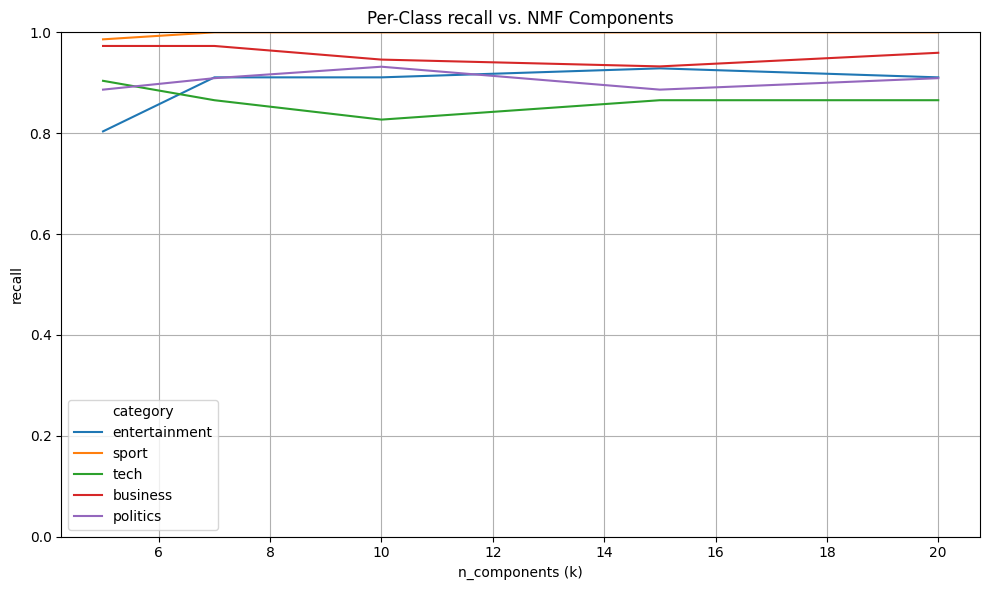

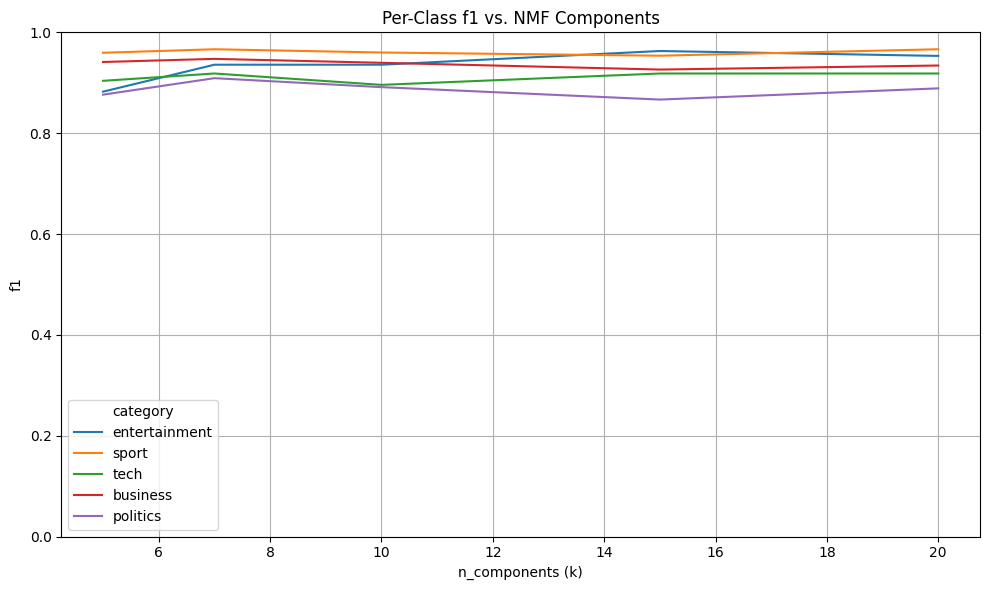

In [56]:
# Convert to DataFrame
df_charted_metrics = pd.DataFrame(charted_metrics)

# Sir Plots-a-lot
for metric in ['precision', 'recall', 'f1']:
  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df_charted_metrics, x="k", y=metric, hue="category"),
  plt.title(f"Per-Class {metric} vs. NMF Components")
  plt.xlabel("n_components (k)")
  plt.ylabel(f"{metric}")
  plt.ylim(0, 1)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## 🪿 Kaggle Submission


#### ➿Data Processing

In [61]:
test_df = pd.read_csv('./data/BBC News Test.csv')

# TF-IDF
X_test_tfidf = vectorizer.transform(test_df['Text'])

# Final NMF model
nmf = NMF(
    n_components=20,
    random_state=42069 # Nice
    )
W = nmf.fit_transform(X_tfidf)

# Final classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(W, data['category'])

# NMF
X_test_nmf = nmf.transform(X_test_tfidf)

# Predict the labels
y_test_pred = clf.predict(X_test_nmf)

# Prepare the submission
submission = pd.DataFrame({
    "ArticleId": test_df["ArticleId"],
    "Category": y_test_pred
})

submission.to_csv("./data/submission.csv", index=False)


In [65]:
!ls -l ./data/

total 4966
-rw------- 1 root root   10369 Dec  2  2019 'BBC News Sample Solution.csv'
-rw------- 1 root root 1712432 Dec  2  2019 'BBC News Test.csv'
-rw------- 1 root root 3351206 Dec  2  2019 'BBC News Train.csv'
-rw------- 1 root root    9367 Jun 23 16:21  submission.csv


In [68]:
# # Zip the folder for submission
# !cd ./data/show_me_the_monet && zip -r ../../images.zip *.jpg

# # Submission Rules: images.zip # I spent way too long on this RFTM
# !mv ./data/show_me_the_monet-cbrechin-20250622.zip ./data/images.zip
# Submit to Kaggle competition
# %cd ./data
!kaggle competitions submit -c learn-ai-bbc -f ./data/submission.csv -m "learn_ai_bbc-cbrechin-20250623"

100% 9.15k/9.15k [00:00<00:00, 14.8kB/s]
Successfully submitted to BBC News Classification

#### 🪛 Submission Screenshot

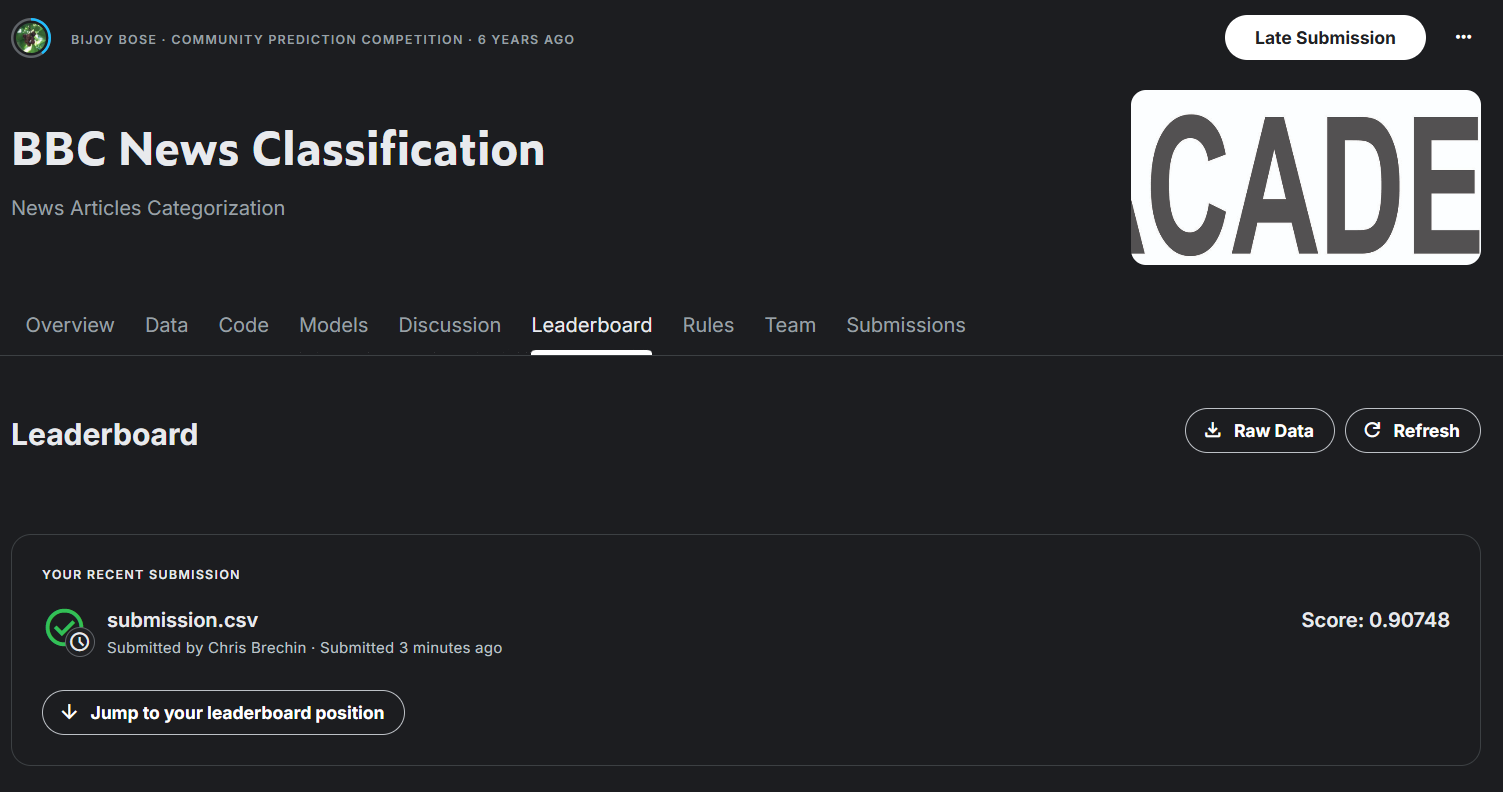

### ⚠️ Note

For some reason, I am not able to see my position on the **Leaderboard** so I have included a screenshot of the record of my submission instead.

## ⚖️ Comparing with Supervised Learning

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    data['category'],
    test_size=0.2,
    random_state=42069 # Nice
)

### 🪓 Train the Classifier

In [71]:
clf_tf_only = LogisticRegression(max_iter=1000)
clf_tf_only.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### 🦹 Evaluate the Model

               precision    recall  f1-score   support

     business       0.95      0.97      0.96        75
entertainment       1.00      0.96      0.98        46
     politics       0.95      0.96      0.96        56
        sport       0.98      1.00      0.99        63
         tech       0.98      0.95      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



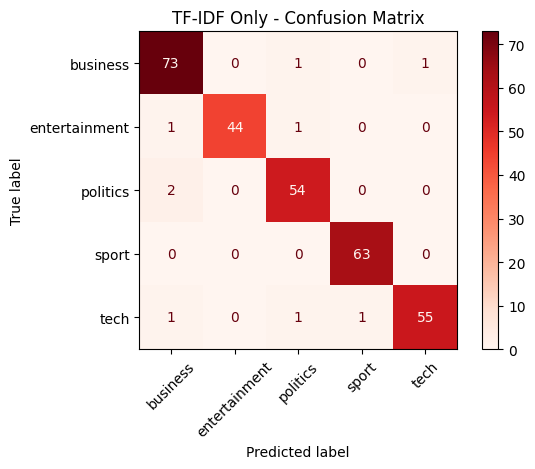

In [72]:
y_pred = clf_tf_only.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, cmap="Reds")
plt.title("TF-IDF Only - Confusion Matrix")
plt.tight_layout()
plt.show()


### 🌖 Compare for Accuracy

In [77]:
from sklearn.metrics import accuracy_score


# TF-IDF and Logistic Regression Only
tfidf_only_accuracy = accuracy_score(y_test, y_pred)
print(f"TF-IDF Only Accuracy: {tfidf_only_accuracy:.4f}")

# NMF model trained on training data
W = nmf.fit_transform(X_tfidf)

# Use same split for comparison
X_train_nmf, X_test_nmf, y_train, y_test = train_test_split(
    W,
    data['category'],
    test_size=0.2,
    random_state=42069 # Nice
)

# Refit classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_nmf, y_train)

# Predict
y_pred_nmf = clf.predict(X_test_nmf)
nmf_accuracy = accuracy_score(y_test, y_pred_nmf)
print(f"NMF Accuracy: {nmf_accuracy:.4f}")

TF-IDF Only Accuracy: 0.9698
NMF Accuracy: 0.9228


### 💗 Testing on Different Training Sample Sizes

In [92]:
def evaluate_models_by_sample_size(X_tfidf, y, sample_sizes=[0.1, 0.2, 0.3, 0.4, 0.5], nmf_k=5):
    results = []

    for frac in sample_sizes:
        # Subsample the training data
        X_sub, _, y_sub, _ = train_test_split(
            X_tfidf,
            y,
            train_size=frac,
            stratify=y,
            random_state=42069 # Nice
          )

        # Split again for evaluation
        X_train_tf, X_test_tf, y_train, y_test = train_test_split(
            X_sub,
            y_sub,
            test_size=0.2,
            random_state=42069 # Nice
            )

        # TF-IDF only
        clf_tf = LogisticRegression(max_iter=1000)
        clf_tf.fit(X_train_tf, y_train)
        y_pred_tf = clf_tf.predict(X_test_tf)
        acc_tf = accuracy_score(y_test, y_pred_tf)

        results.append({
            "sample_frac": frac,
            "model": "TF-IDF",
            "accuracy": acc_tf
        })

        # NMF
        nmf = NMF(n_components=nmf_k, random_state=42)
        X_train_nmf = nmf.fit_transform(X_train_tf)
        X_test_nmf = nmf.transform(X_test_tf)

        clf_nmf = LogisticRegression(max_iter=1000)
        clf_nmf.fit(X_train_nmf, y_train)
        y_pred_nmf = clf_nmf.predict(X_test_nmf)
        acc_nmf = accuracy_score(y_test, y_pred_nmf)

        results.append({
            "sample_frac": frac,
            "model": f"NMF (k={nmf_k})",
            "accuracy": acc_nmf
        })

    return pd.DataFrame(results)

In [94]:
efficiency_df = evaluate_models_by_sample_size(X_tfidf, data['category'], sample_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], nmf_k=5)

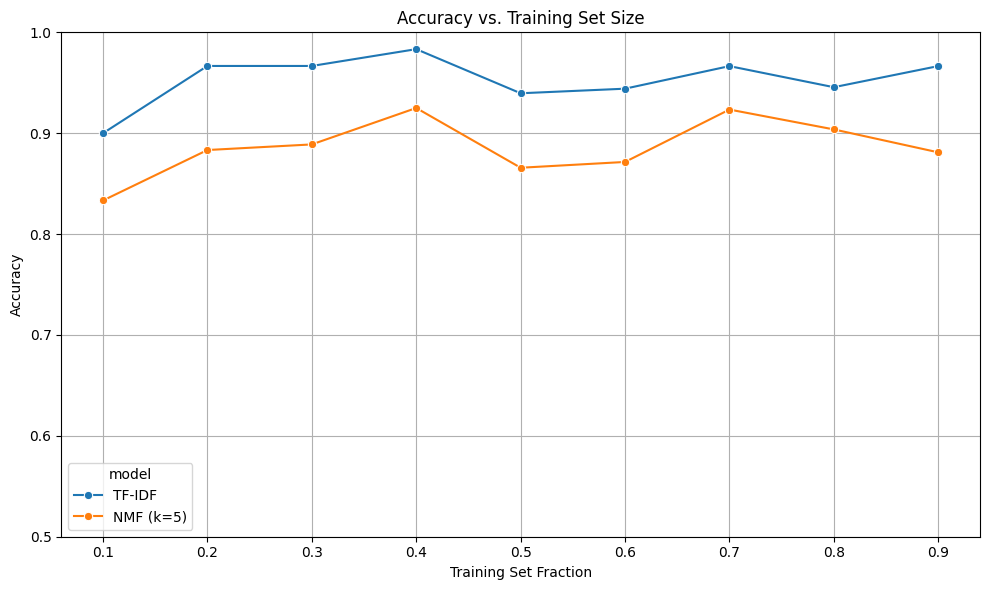

In [95]:
# Let's get Down to Business...
# To plot, the Huns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=efficiency_df,
    x="sample_frac",
    y="accuracy",
    hue="model",
    marker="o"
    )
plt.title("Accuracy vs. Training Set Size")
plt.xlabel("Training Set Fraction")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧪 Data Efficiency and Overfitting Analysis

I compared TF-IDF and NMF-based classifiers across increasing training set sizes (`10%` to `50%`). As expected, both models showed improved accuracy with more data.

- **TF-IDF and Logistic Regression** consistently outperformed **NMF**, achieving near-perfect accuracy with just 30–50% of the training set.
- **NMF (k=5)** showed diminishing returns beyond `40%`. It might have something to do with the low `k = 5` values.

There doesn't seem to be much over-fitting happening. However, I kept everything quite small and manageable. The trend does continue towards a constant with both models. After `40%` is partitioned for training, we can see that the models do not benefit from more training.

The reported accuracy suggests that TF-IDF is highly data-efficient for this task, while NMF may require tuning to match performance.

# Part 2: 🎬 Applying NMF to the Movie Ratings Data

In [103]:
# !unzip ./data/movie_recommendation_files.zip -d ./data/
# !mv ./data/Files/* ./data/
# !rm -d ./data/Files
!find ./data/ -type f -mtime -30 -ls

       55     10 -rw-------   1 root     root         9367 Jun 23 16:21 ./data/submission.csv
       60   4601 -rw-------   1 root     root      4711088 Jun 23 17:14 ./data/movie_recommendation_files.zip
       68    245 -rw-------   1 root     root       250402 Jun 23 17:12 ./data/movies.csv
       71   3386 -rw-------   1 root     root      3466730 Jun 23 17:12 ./data/test.csv
       74   7898 -rw-------   1 root     root      8086756 Jun 23 17:12 ./data/train.csv
       77    108 -rw-------   1 root     root       110238 Jun 23 17:13 ./data/users.csv


In [105]:
train = pd.read_csv('./data/train.csv')
users = pd.read_csv('./data/users.csv')
movies = pd.read_csv('./data/movies.csv')

### 🕶️ Create the Utility Matrix

In [106]:
# Get ID mappings
user_ids = sorted(train['uID'].unique())
movie_ids = sorted(train['mID'].unique())
user_map = {uid: i for i, uid in enumerate(user_ids)}
movie_map = {mid: i for i, mid in enumerate(movie_ids)}

# Shape
n_users = len(user_ids)
n_movies = len(movie_ids)

import numpy as np

# Create full utility matrix
R = np.zeros((n_users, n_movies))

for _, row in train.iterrows():
    u_idx = user_map[row['uID']]
    m_idx = movie_map[row['mID']]
    R[u_idx, m_idx] = row['rating']

### 🍏 Apply NMF to Predict Missing Ratings

In [107]:
nmf = NMF(
    n_components=20,
    max_iter=500,
    random_state=42069 # Nice # It never gets old...
    )
W = nmf.fit_transform(R)
H = nmf.components_
R_hat = np.dot(W, H)  # Reconstructed ratings matrix

### 💝 Evaluate on Test Data

In [110]:
from sklearn.metrics import mean_squared_error

test = pd.read_csv('./data/test.csv')

y_true = []
y_pred = []

for _, row in test.iterrows():
    u_idx = user_map.get(row['uID'])
    m_idx = movie_map.get(row['mID'])

    if u_idx is not None and m_idx is not None:
        y_true.append(row['rating'])
        y_pred.append(R_hat[u_idx, m_idx])

# Compute RMSE
from math import sqrt
rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"NMF RMSE on test set: {rmse:.4f}")


NMF RMSE on test set: 2.8609


### 🔨 Tinkering

In [114]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

# Compute global average rating from training data
global_avg = train['rating'].mean()
print(f"Global average rating: {global_avg:.4f}")

# Predict global mean for all test entries
y_true = test['rating'].tolist()
y_pred = [global_avg] * len(y_true)

# Compute RMSE
baseline_rmse = sqrt(mean_squared_error(y_true, y_pred))
print(f"Global mean baseline RMSE: {baseline_rmse:.4f}")

Global average rating: 3.5816
Global mean baseline RMSE: 1.1162


### 🍮 Discuss the Results

## 🧩 NMF vs. Baseline Comparison

The `sklearn` NMF model achieved an RMSE of **2.86**, which is significantly worse than a naive baseline model that predicts the global average rating for every user-item pair.

| Model                      | RMSE   |
|---------------------------|--------|
| Global Mean Baseline      | 1.1162 |
| NMF (scikit-learn, k=20)  | 2.8609 |

My result highlights a major limitation of the NMF implemented in `sklearn`. NMF assumes all unobserved ratings are `0`. This distorts predicted values.

By populating with the `global_avg`, the baseline model is seemingly unaffected by missing data making it a stronger default approach.

To improve performance, it was recommended to me to use libraries like `Surprise`, which properly handle sparse rating data with implicit masking and bias modeling. Unfortunately, that would have required a downgrade of my `numpy` version. I opted not to do that because I am a chicken.